In [3]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [4]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

import imageio
from IPython.display import HTML, display

In [6]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):

  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

In [7]:
model_name = "movenet_lightning"
module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
input_size = 192
def movenet(input_image):
  """Runs detection on an input image.

  Args:
    input_image: A [1, height, width, 3] tensor represents the input image
      pixels. Note that the height/width should already be resized and match the
      expected input resolution of the model before passing into this function.

  Returns:
    A [1, 1, 17, 3] float numpy array representing the predicted keypoint
    coordinates and scores.
  """
  model = module.signatures['serving_default']

  # SavedModel format expects tensor type of int32.
  input_image = tf.cast(input_image, dtype=tf.int32)
  # Run model inference.
  outputs = model(input_image)
  # Output is a [1, 1, 17, 3] tensor.
  keypoints_with_scores = outputs['output_0'].numpy()
  return keypoints_with_scores

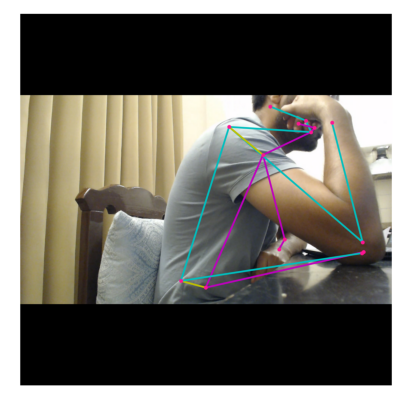

In [8]:
# Load the input image.
image_path = '/content/bimg4.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [9]:
# Load the input image.
image_path = '/content/bimg4.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)
print(keypoints_with_scores)

[[[[0.31784153 0.7829735  0.34639126]
   [0.3063928  0.7925164  0.34698603]
   [0.28697374 0.76907074 0.37711683]
   [0.29532155 0.74869657 0.3427768 ]
   [0.24907294 0.6730181  0.3980442 ]
   [0.37939107 0.65359205 0.26404926]
   [0.30387646 0.5622232  0.7500728 ]
   [0.6067294  0.71211326 0.12267793]
   [0.61422914 0.921869   0.37107652]
   [0.6334686  0.6967964  0.35972238]
   [0.292022   0.83941555 0.30176285]
   [0.73669124 0.49948883 0.33916715]
   [0.718634   0.43246615 0.25405464]
   [0.6408514  0.9247767  0.26568994]
   [0.64392835 0.92025125 0.4116451 ]
   [0.6490809  0.8927645  0.04148269]
   [0.6359686  0.7334912  0.07955692]]]]


In [10]:
#Data augmentation:
import cv2
import os

# Define the path of the folder containing the images
folder_path = '/content/gdrive/MyDrive/Dataset/good'

# Get a list of the image filenames in the folder
filenames = os.listdir(folder_path)

# Iterate over the image filenames
for filename in filenames:
    # Construct the path of the image file
    file_path = os.path.join(folder_path, filename)
    
    # Load the image
    image = cv2.imread(file_path)
    
    # Invert the image horizontally
    inverted_image = cv2.flip(image, 1)
    
    # Construct the paths of the original and inverted images
    original_path = file_path
    inverted_path = os.path.join(folder_path, 'inverted_' + filename)
    
    # Save the original and inverted images
    cv2.imwrite(original_path, image)
    cv2.imwrite(inverted_path, inverted_image)


In [11]:


# Define keypoint dictionary and parents
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

KEYPOINT_PARENTS = {
    0: -1,
    1: 0,
    2: 0,
    3: 1,
    4: 2,
    5: 0,
    6: 0,
    7: 5,
    8: 6,
    9: 7,
    10: 8,
    11: 5,
    12: 6,
    13: 11,
    14: 12,
    15: 13,
    16: 14
}

# Define function to calculate angle between three keypoints
def get_angle(a, b, c):
    """Calculate cosine of the angle between three points in 2D space"""
    # Calculate the vectors between the three points
    ux, uy = a[0]-b[0], a[1]-b[1]
    vx, vy = c[0]-b[0], c[1]-b[1]

    # Calculate the dot product of the vectors
    dot_product = ux*vx + uy*vy

    # Calculate the magnitudes of the vectors
    mag1 = ((ux)**2 + (uy)**2)**0.5
    mag2 = ((vx)**2 + (vy)**2)**0.5

    # Calculate the cosine of the angle using the dot product and magnitudes
    cos_angle = dot_product / (mag1 * mag2)

    # Return the cosine of the angle
    return round(cos_angle,4)





In [12]:
def image_to_angle_to_xls(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)
  input_image = tf.expand_dims(image, axis=0)
  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
  keypoints_with_scores = movenet(input_image)
  # Access coordinates of keypoints
  nose = keypoints_with_scores[0][0][KEYPOINT_DICT['nose']][0:2]
  left_shoulder = keypoints_with_scores[0][0][KEYPOINT_DICT['left_shoulder']][0:2]
  right_shoulder = keypoints_with_scores[0][0][KEYPOINT_DICT['right_shoulder']][0:2]
  left_hip = keypoints_with_scores[0][0][KEYPOINT_DICT['left_hip']][0:2]
  right_hip = keypoints_with_scores[0][0][KEYPOINT_DICT['right_hip']][0:2]
  left_knee = keypoints_with_scores[0][0][KEYPOINT_DICT['left_knee']][0:2]
  right_knee = keypoints_with_scores[0][0][KEYPOINT_DICT['right_knee']][0:2]
  left_ear = keypoints_with_scores[0][0][KEYPOINT_DICT['left_ear']][0:2]
  right_ear = keypoints_with_scores[0][0][KEYPOINT_DICT['right_ear']][0:2]

  # Calculate angles
  nose_rs_rh_angle = get_angle(nose, right_shoulder, right_hip)
  nose_ls_lh_angle = get_angle(nose, left_shoulder, left_hip)
  rear_rsrh_angle = get_angle(right_ear, right_shoulder, right_hip)
  lear_lslh_angle = get_angle(left_ear, left_shoulder, left_hip)
  lsh_lh_lk_angle = get_angle(left_shoulder, left_hip, left_knee)
  rsh_rh_rk_angle = get_angle(right_shoulder, right_hip, right_knee)
  nose_rh_rk_angle = get_angle(nose, right_hip, right_knee)
  nose_lh_lk_angle = get_angle(nose, left_hip, left_knee)
  rsh_lh_lk_angle = get_angle(right_shoulder, left_hip, left_knee)
  lsh_rh_rk_angle = get_angle(left_shoulder, right_hip, right_knee)
  return [nose_rs_rh_angle,nose_ls_lh_angle,rear_rsrh_angle,lear_lslh_angle,lsh_lh_lk_angle,rsh_rh_rk_angle,nose_rh_rk_angle,nose_lh_lk_angle,rsh_lh_lk_angle,lsh_rh_rk_angle]
  

In [13]:
print(image_to_angle_to_xls('/content/bimg4.jpg'))

[-0.2377, -0.7521, -0.6908, -0.9049, 0.5882, 0.4396, 0.7647, 0.7289, 0.3575, 0.6666]


In [14]:
import os

# Define a list of image file extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

# Define the function to check if a path is to an image
def is_image_path(file_path):
    # Split the file path into its base and extension
    _, extension = os.path.splitext(file_path)
    
    # Check if the extension is in the list of image file extensions
    if extension.lower() in image_extensions:
        return True
    else:
        return False


In [15]:
import openpyxl
import os
# Open a new Excel workbook
workbook = openpyxl.Workbook()

# Create a new worksheet
worksheet = workbook.active

# Define the column names
column_names = ['nose_rs_rh_angle', 'nose_ls_lh_angle', 'rear_rsrh_angle',
                'lear_lslh_angle', 'lsh_lh_lk_angle', 'rsh_rh_rk_angle',
                'nose_rh_rk_angle', 'nose_lh_lk_angle', 'rsh_lh_lk_angle',
                'lsh_rh_rk_angle', 'label']

# Write the column names to the first row of the worksheet
for i, column_name in enumerate(column_names):
    worksheet.cell(row=1, column=i+1, value=column_name)

# Iterate over the images in the "good" and "bad" folders
for label, folder_name in enumerate(['bad', 'good']):
    # Get the path of the folder
    folder_path = os.path.join('/content/gdrive/MyDrive/Dataset', folder_name)
    
    # Get a list of the image filenames in the folder
    filenames = os.listdir(folder_path)
    
    # Iterate over the image filenames
    for i, filename in enumerate(filenames):
        # Get the path of the image file
        image_path = os.path.join(folder_path, filename)
        print(image_path)
        # Calculate the angles for the image
        if not is_image_path(image_path):
          continue
        angles = image_to_angle_to_xls(image_path)
        print(angles)
        # Write the angles and label to the worksheet
        for j, angle in enumerate(angles):
            worksheet.cell(row=i+2, column=j+1, value=angle)
        worksheet.cell(row=i+2, column=len(angles)+1, value=label)

# Save the workbook to an Excel file
workbook.save('angles.xlsx')


/content/gdrive/MyDrive/Dataset/bad/inverted_img5.jpg
[-0.472, -0.0884, -0.8889, -0.5023, -0.5772, -0.3363, -0.0861, -0.1909, -0.4119, -0.5062]
/content/gdrive/MyDrive/Dataset/bad/inverted_img4.jpg
[-0.5913, -0.1767, -0.8411, -0.3702, 0.5253, 0.5466, 0.7142, 0.7633, 0.6231, 0.4512]
/content/gdrive/MyDrive/Dataset/bad/inverted_img9.jpg
[-0.9297, -0.3871, -0.9945, -0.7128, 0.2373, 0.2453, 0.3459, 0.6147, 0.6015, -0.1805]
/content/gdrive/MyDrive/Dataset/bad/inverted_img10.jpg
[-0.801, -0.375, -0.9934, -0.7251, -0.0145, -0.1498, 0.0279, 0.3444, 0.2657, -0.4128]
/content/gdrive/MyDrive/Dataset/bad/inverted_img3.jpg
[-0.9905, -0.2884, -0.9508, -0.6117, 0.0756, 0.2551, 0.3042, 0.4834, 0.5389, -0.1915]
/content/gdrive/MyDrive/Dataset/bad/inverted_bimg2.jpg
[-0.9997, -0.4258, -0.833, -0.7655, 0.6117, 0.7739, 0.7688, 0.9034, 0.9397, 0.2548]
/content/gdrive/MyDrive/Dataset/bad/inverted_bimg3.jpg
[-0.9709, -0.5539, -0.947, -0.8724, 0.5143, 0.5967, 0.6593, 0.7954, 0.7972, 0.213]
/content/gdrive/MyD

In [16]:
import pandas as pd
# read the dataset from the xls file
df = pd.read_excel('/content/angles.xlsx')

# shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

# write the shuffled dataset to a new xls file
df.to_excel('/content/shuffled_dataset.xlsx', index=False)

In [17]:

# Read the XLS file into a pandas dataframe
df = pd.read_excel('/content/shuffled_dataset.xlsx')

# Write the dataframe to a CSV file
df.to_csv('/content/shuffled_dataset.csv', index=False)


Using the trained model:

In [33]:
import pickle
from sklearn.linear_model import LogisticRegression


def image_classification(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)
  # Resize and pad the image to keep the aspect ratio and fit the expected size.
  input_image = tf.expand_dims(image, axis=0)
  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

  # Run model inference.
  keypoints_with_scores = movenet(input_image)

  # Visualize the predictions with image.
  display_image = tf.expand_dims(image, axis=0)
  display_image = tf.cast(tf.image.resize_with_pad(
      display_image, 1280, 1280), dtype=tf.int32)
  output_overlay = draw_prediction_on_image(
      np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

  plt.figure(figsize=(5, 5))
  plt.imshow(output_overlay)
  _ = plt.axis('off')

  with open('/content/modelLR.pkl', 'rb') as f:
    modelLR = pickle.load(f)

  angles=image_to_angle_to_xls(image_path)
  # Example of new data for prediction
  new_data = np.array([angles])

  # Make predictions on new data using the loaded model
  predictions = modelLR.predict(new_data)

  if(predictions[0]==1):
    print('GOOD POSTURE')
  else:
    print('BAD POSTURE')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


GOOD POSTURE


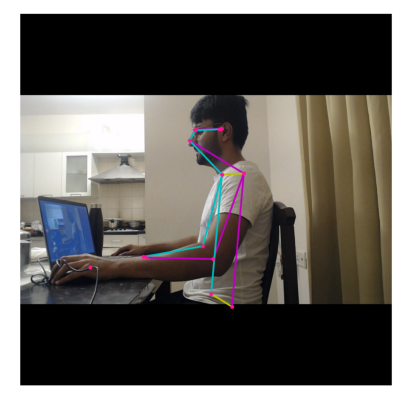

In [36]:
image_classification('/content/gdrive/MyDrive/Dataset/good/inverted_bmimfri.jpg')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


BAD POSTURE


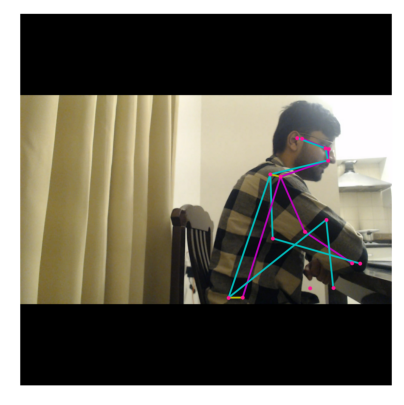

In [37]:
image_classification('/content/gdrive/MyDrive/Dataset/bad/bgfom.jpg')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


BAD POSTURE


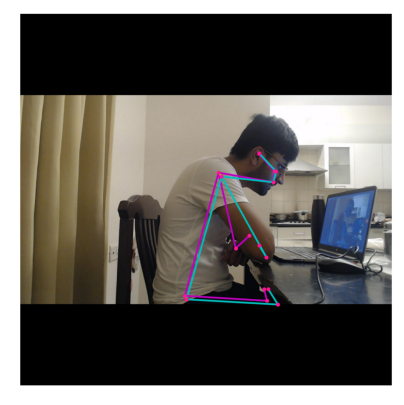

In [38]:
image_classification('/content/gdrive/MyDrive/Dataset/bad/bmimg3.jpg')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


GOOD POSTURE


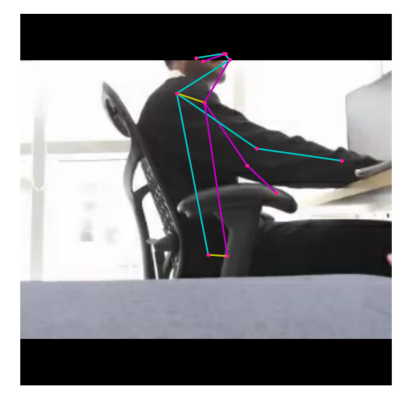

In [39]:
image_classification('/content/gdrive/MyDrive/Dataset/good/img6.jpg')